# PayNet Assessment

In [2]:
import pandas as pd
import json
import re
import numpy as np
# import pyspark.pandas as ps
# from pyspark.sql import SparkSession

### Load JSON file into dataframe

Due to the dataset is relatively large, I'll proceed to load the data in partially (first 1000 rows).

At the same time, we will do some quality check on these columns:
1. merch_lat, merch_long by checking the range of the data
2. is_fraud for the unique data

In [3]:
partial_data = pd.read_json("cc_sample_transaction.json", lines=True, nrows=1000)

In [4]:
partial_data.head(n=10)

,Unnamed: 0,trans_date_trans_time,cc_bic,cc_num,merchant,category,amt,personal_detail,trans_num,merch_lat,merch_long,is_fraud,merch_zipcode,merch_eff_time,merch_last_update_time
0,0,2019-01-01 00:00:18,CITIUS33CHI,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,"{""person_name"":""Jennifer,Banks,eeeee"",""gender""...",0b242abb623afc578575680df30655b9,36.011293,-82.048315,0,28705.0,2012-01-01 00:00:18.798532,2012-01-01 00:00:18.666
1,1,2019-01-01 00:00:44,ADMDUS41,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,"{""person_name"":""Stephanie,Gill,eeeee"",""gender""...",1f76529f8574734946361c461b024d99,49.159047,-118.186462,0,NaN,2012-01-01 00:00:44.867960,1974-03-15 00:00:04.479
2,2,2019-01-01 00:00:51,Null,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,"{""person_name"":""Edward@Sanchez"",""gender"":""M"",""...",a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,83236.0,2012-01-01 00:00:51.506840,2012-01-01 00:00:51.286
3,3,2019-01-01 00:01:16,DEUTUS33TRF,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,"{""person_name"":""Jeremy/White, !"",""gender"":""M"",...",6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0,NaN,2012-01-01 00:01:16.794698,2012-01-01 00:01:16.365
4,4,2019-01-01 00:03:06,APBCUS61,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,"{""person_name"":""Tyler@Garcia"",""gender"":""M"",""ad...",a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0,22844.0,2012-01-01 00:03:06.746376,1974-03-15 00:00:18.681
5,5,2019-01-01 00:04:08,APBCUS61,4767265376804500,"fraud_Stroman, Hudson and Erdman",gas_transport,94.63,"{""person_name"":""Jennifer,Conner,eeeee"",""gender...",189a841a0a8ba03058526bcfe566aab5,40.653382,-76.152667,0,17972.0,2012-01-01 00:04:08.271406,2012-01-01 00:04:08.483
6,6,2019-01-01 00:04:42,APBCUS61,30074693890476,fraud_Rowe-Vandervort,grocery_net,44.54,"{""person_name"":""Kelsey, , Richards NOOOO"",""gen...",83ec1cc84142af6e2acf10c44949e720,37.162705,-100.153370,0,NaN,2012-01-01 00:04:42.274130,2012-01-01 00:04:42.247
7,7,2019-01-01 00:05:08,NA,6011360759745864,fraud_Corwin-Collins,gas_transport,71.65,"{""person_name"":""Steven, Williams"",""gender"":""M""...",6d294ed2cc447d2c71c7171a3d54967c,38.948089,-78.540296,0,22644.0,2012-01-01 00:05:08.837349,2012-01-01 00:05:08.152
8,8,2019-01-01 00:05:18,ACEEUS31,4922710831011201,fraud_Herzog Ltd,misc_pos,4.27,"{""person_name"":""Heather, , Chase NOOOO"",""gende...",fc28024ce480f8ef21a32d64c93a29f5,40.351813,-79.958146,0,15236.0,2012-01-01 00:05:18.245892,2012-01-01 00:05:18.278
9,9,2019-01-01 00:06:01,DEUTUS33TRF,2720830304681674,"fraud_Schoen, Kuphal and Nitzsche",grocery_pos,198.39,"{""person_name"":""Melissa@Aguilar"",""gender"":""F"",...",3b9014ea8fb80bd65de0b1463b00b00e,37.179198,-87.485381,0,42442.0,2012-01-01 00:06:01.965234,2012-01-01 00:06:01.857


In [5]:
# Check the uniqueness of the column
partial_data["is_fraud"].unique()

array([0], dtype=int64)

In [6]:
print(f"\"amt\" is all valid: {all(partial_data['amt'] >= 0)}")

"amt" is all valid: True


In [7]:
print(f"\"merch_lat\" is all in range: {all(partial_data['merch_lat'].between(-180, 180))}")
print(f"\"merch_long\" is all in range: {all(partial_data['merch_long'].between(-180, 180))}")

"merch_lat" is all in range: True
"merch_long" is all in range: True


Here, we can see the personal detail is located in the column `personal_detail`. The next step will be focusing on this column first before working on other columns.

In [8]:
personal_detail_df = pd.json_normalize(partial_data["personal_detail"].map(lambda x: json.loads(x)))

personal_detail_df.head(n=10)

,person_name,gender,address,lat,long,city_pop,job,dob
0,"Jennifer,Banks,eeeee",F,"{""street"":""561 Perry Cove"",""city"":""Moravian Fa...",36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09
1,"Stephanie,Gill,eeeee",F,"{""street"":""43039 Riley Greens Suite 393"",""city...",48.8878,-118.2105,149,Special educational needs teacher,1978-06-21
2,Edward@Sanchez,M,"{""street"":""594 White Dale Suite 530"",""city"":""M...",42.1808,-112.262,4154,Nature conservation officer,1962-01-19
3,"Jeremy/White, !",M,"{""street"":""9443 Cynthia Court Apt. 038"",""city""...",46.2306,-112.1138,1939,Patent attorney,1967-01-12
4,Tyler@Garcia,M,"{""street"":""408 Bradley Rest"",""city"":""Doe Hill""...",38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28
5,"Jennifer,Conner,eeeee",F,"{""street"":""4655 David Island"",""city"":""Dublin"",...",40.375,-75.2045,2158,Transport planner,1961-06-19
6,"Kelsey, , Richards NOOOO",F,"{""street"":""889 Sarah Station Suite 624"",""city""...",37.9931,-100.9893,2691,Arboriculturist,1993-08-16
7,"Steven, Williams",M,"{""street"":""231 Flores Pass Suite 720"",""city"":""...",38.8432,-78.6003,6018,"Designer, multimedia",1947-08-21
8,"Heather, , Chase NOOOO",F,"{""street"":""6888 Hicks Stream Suite 954"",""city""...",40.3359,-79.6607,1472,Public affairs consultant,1941-03-07
9,Melissa@Aguilar,F,"{""street"":""21326 Taylor Squares Suite 708"",""ci...",36.522,-87.34899999999999,151785,Pathologist,1974-03-28


After extracting the `personal_detail` column, the address is still nested within the layer. I'll proceed to flatten it here.

In [9]:
personal_address_df = pd.json_normalize(personal_detail_df["address"].map(lambda x: json.loads(x)))

personal_address_df.head(n=10)

,street,city,state,zip
0,561 Perry Cove,Moravian Falls,NC,28654
1,43039 Riley Greens Suite 393,Orient,WA,99160
2,594 White Dale Suite 530,Malad City,ID,83252
3,9443 Cynthia Court Apt. 038,Boulder,MT,59632
4,408 Bradley Rest,Doe Hill,VA,24433
5,4655 David Island,Dublin,PA,18917
6,889 Sarah Station Suite 624,Holcomb,KS,67851
7,231 Flores Pass Suite 720,Edinburg,VA,22824
8,6888 Hicks Stream Suite 954,Manor,PA,15665
9,21326 Taylor Squares Suite 708,Clarksville,TN,37040


Now, everything is flatten now. I'll proceed to work on personal name data transformation first. I'll first sample a random data to take a look

In [10]:
personal_detail_df["person_name"].sample(100).to_list()

['Monica,Cohen,eeeee',
 'Renee@Parrish',
 'John/Vega, !',
 'Jennifer,Conner,eeeee',
 'Tanner@Davis',
 'Kristina,Lewis,eeeee',
 'Christopher/Ortega, !',
 'Ronald@Carson',
 'Jeffery|Sanders!!!',
 'Julie|Johnson!!!',
 'Debra, , Eaton NOOOO',
 'Lisa, , Mendez NOOOO',
 'Valerie, Davis',
 'Tanner,Carroll,eeeee',
 'Eddie, , Mendez NOOOO',
 'Heather@Chase',
 'Joseph/Moody, !',
 'Kelsey,Richards,eeeee',
 'Melinda, Gutierrez',
 'Kelly,Zimmerman,eeeee',
 'Bryan,Miller,eeeee',
 'Linda@Davis',
 'Erik, Stevens',
 'Margaret@Gibson',
 'Philip,Hart,eeeee',
 'Allison/Ayala, !',
 'George, Smith',
 'Theresa@Blackwell',
 'Jason|Gray!!!',
 'James, Cooper',
 'Jesse@Roberts',
 'Melissa|Meza!!!',
 'Melody,Thompson,eeeee',
 'Heather|Chase!!!',
 'Monica/Tucker, !',
 'Mark, Wood',
 'Robert|Hall!!!',
 'Drew, Garcia',
 'Lawrence@Davis',
 'Thomas,Hale,eeeee',
 'Theresa,Blackwell,eeeee',
 'Danielle, Yu',
 'Angela/Taylor, !',
 'Timothy@Gomez',
 'Jodi,Rodriguez,eeeee',
 'Juan|Henry!!!',
 'Mary@Lewis',
 'Joanna,Hudson,e

From the sampling dataset, I have concluded the points below:
1. The name is well-structured in the way that the name is still quite completed, but with some unused/extra delimiters (non-words character)
2. The name is well defined with the first character capitalized

So, the proceed ways are as follow:
1. Replace the non-character with white space
2. Try to find the string with first character capitalized

With the simple sanity check, we can first conclude that it will work well.

In [11]:
intermediate_splitted_name = personal_detail_df["person_name"].map(lambda s: re.sub(r"\W", " ", s)).map(lambda s: re.findall(r"[A-Z][a-z]+", s))

In [12]:
# check the length of the splitted name
intermediate_splitted_name.map(len).unique()

array([2], dtype=int64)

### Full load the data

In addition, we will do the checking again.

In [13]:
full_data = pd.read_json("cc_sample_transaction.json", lines=True)

full_data.shape

(1296675, 15)

In [14]:
# Check the uniqueness of the column
print(f"Value in \"is_fraud\": {full_data['is_fraud'].unique()}")
print(f"\"amt\" is all valid: {all(full_data['amt'] >= 0)}")
print(f"\"merch_lat\" is all in range: {all(full_data['merch_lat'].between(-180, 180))}")
print(f"\"merch_long\" is all in range: {all(full_data['merch_long'].between(-180, 180))}")

Value in "is_fraud": [0 1]
"amt" is all valid: True
"merch_lat" is all in range: True
"merch_long" is all in range: True


In [15]:
personal_detail_full_data = pd.json_normalize(full_data["personal_detail"].map(lambda x: json.loads(x)))

personal_address_full_data = pd.json_normalize(personal_detail_full_data["address"].map(lambda x: json.loads(x)))

In [16]:
full_intermediate_splitted_name = personal_detail_full_data["person_name"].map(lambda s: re.sub(r"\W", " ", s)).map(lambda s: re.findall(r"[A-Z][a-z]+", s))

Looks good overall with the length, here I'll assume it is correct.

In [17]:
full_intermediate_splitted_name.map(len).unique()

array([2], dtype=int64)

Then, we will proceed to transform the personal information here and merge back to the original dataframe with index. 

**As the index will be consistent throughout the column selection, index is sufficient to make it joining.**

In [18]:
personal_detail_full_data["first"] = full_intermediate_splitted_name.apply(lambda x: x[0])  # first
personal_detail_full_data["last"] = full_intermediate_splitted_name.apply(lambda x: x[1])  # last

personal_detail_with_address_full_data = personal_detail_full_data.merge(personal_address_full_data, left_index=True, right_index=True)

In [19]:
personal_detail_with_address_full_data.head(n = 10)

,person_name,gender,address,lat,long,city_pop,job,dob,first,last,street,city,state,zip
0,"Jennifer,Banks,eeeee",F,"{""street"":""561 Perry Cove"",""city"":""Moravian Fa...",36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,Jennifer,Banks,561 Perry Cove,Moravian Falls,NC,28654
1,"Stephanie,Gill,eeeee",F,"{""street"":""43039 Riley Greens Suite 393"",""city...",48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,Stephanie,Gill,43039 Riley Greens Suite 393,Orient,WA,99160
2,Edward@Sanchez,M,"{""street"":""594 White Dale Suite 530"",""city"":""M...",42.1808,-112.262,4154,Nature conservation officer,1962-01-19,Edward,Sanchez,594 White Dale Suite 530,Malad City,ID,83252
3,"Jeremy/White, !",M,"{""street"":""9443 Cynthia Court Apt. 038"",""city""...",46.2306,-112.1138,1939,Patent attorney,1967-01-12,Jeremy,White,9443 Cynthia Court Apt. 038,Boulder,MT,59632
4,Tyler@Garcia,M,"{""street"":""408 Bradley Rest"",""city"":""Doe Hill""...",38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,Tyler,Garcia,408 Bradley Rest,Doe Hill,VA,24433
5,"Jennifer,Conner,eeeee",F,"{""street"":""4655 David Island"",""city"":""Dublin"",...",40.375,-75.2045,2158,Transport planner,1961-06-19,Jennifer,Conner,4655 David Island,Dublin,PA,18917
6,"Kelsey, , Richards NOOOO",F,"{""street"":""889 Sarah Station Suite 624"",""city""...",37.9931,-100.9893,2691,Arboriculturist,1993-08-16,Kelsey,Richards,889 Sarah Station Suite 624,Holcomb,KS,67851
7,"Steven, Williams",M,"{""street"":""231 Flores Pass Suite 720"",""city"":""...",38.8432,-78.6003,6018,"Designer, multimedia",1947-08-21,Steven,Williams,231 Flores Pass Suite 720,Edinburg,VA,22824
8,"Heather, , Chase NOOOO",F,"{""street"":""6888 Hicks Stream Suite 954"",""city""...",40.3359,-79.6607,1472,Public affairs consultant,1941-03-07,Heather,Chase,6888 Hicks Stream Suite 954,Manor,PA,15665
9,Melissa@Aguilar,F,"{""street"":""21326 Taylor Squares Suite 708"",""ci...",36.522,-87.34899999999999,151785,Pathologist,1974-03-28,Melissa,Aguilar,21326 Taylor Squares Suite 708,Clarksville,TN,37040


Looks good overall. I'll now merge it back to the original dataframe

In [20]:
compiled_full_data = full_data.merge(personal_detail_with_address_full_data, left_index=True, right_index=True)

In [21]:
compiled_full_data.head(n = 10)

,Unnamed: 0,trans_date_trans_time,cc_bic,cc_num,merchant,category,amt,personal_detail,trans_num,merch_lat,...,long,city_pop,job,dob,first,last,street,city,state,zip
0,0,2019-01-01 00:00:18,CITIUS33CHI,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,"{""person_name"":""Jennifer,Banks,eeeee"",""gender""...",0b242abb623afc578575680df30655b9,36.011293,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,Jennifer,Banks,561 Perry Cove,Moravian Falls,NC,28654
1,1,2019-01-01 00:00:44,ADMDUS41,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,"{""person_name"":""Stephanie,Gill,eeeee"",""gender""...",1f76529f8574734946361c461b024d99,49.159047,...,-118.2105,149,Special educational needs teacher,1978-06-21,Stephanie,Gill,43039 Riley Greens Suite 393,Orient,WA,99160
2,2,2019-01-01 00:00:51,Null,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,"{""person_name"":""Edward@Sanchez"",""gender"":""M"",""...",a1a22d70485983eac12b5b88dad1cf95,43.150704,...,-112.262,4154,Nature conservation officer,1962-01-19,Edward,Sanchez,594 White Dale Suite 530,Malad City,ID,83252
3,3,2019-01-01 00:01:16,DEUTUS33TRF,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,"{""person_name"":""Jeremy/White, !"",""gender"":""M"",...",6b849c168bdad6f867558c3793159a81,47.034331,...,-112.1138,1939,Patent attorney,1967-01-12,Jeremy,White,9443 Cynthia Court Apt. 038,Boulder,MT,59632
4,4,2019-01-01 00:03:06,APBCUS61,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,"{""person_name"":""Tyler@Garcia"",""gender"":""M"",""ad...",a41d7549acf90789359a9aa5346dcb46,38.674999,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,Tyler,Garcia,408 Bradley Rest,Doe Hill,VA,24433
5,5,2019-01-01 00:04:08,APBCUS61,4767265376804500,"fraud_Stroman, Hudson and Erdman",gas_transport,94.63,"{""person_name"":""Jennifer,Conner,eeeee"",""gender...",189a841a0a8ba03058526bcfe566aab5,40.653382,...,-75.2045,2158,Transport planner,1961-06-19,Jennifer,Conner,4655 David Island,Dublin,PA,18917
6,6,2019-01-01 00:04:42,APBCUS61,30074693890476,fraud_Rowe-Vandervort,grocery_net,44.54,"{""person_name"":""Kelsey, , Richards NOOOO"",""gen...",83ec1cc84142af6e2acf10c44949e720,37.162705,...,-100.9893,2691,Arboriculturist,1993-08-16,Kelsey,Richards,889 Sarah Station Suite 624,Holcomb,KS,67851
7,7,2019-01-01 00:05:08,NA,6011360759745864,fraud_Corwin-Collins,gas_transport,71.65,"{""person_name"":""Steven, Williams"",""gender"":""M""...",6d294ed2cc447d2c71c7171a3d54967c,38.948089,...,-78.6003,6018,"Designer, multimedia",1947-08-21,Steven,Williams,231 Flores Pass Suite 720,Edinburg,VA,22824
8,8,2019-01-01 00:05:18,ACEEUS31,4922710831011201,fraud_Herzog Ltd,misc_pos,4.27,"{""person_name"":""Heather, , Chase NOOOO"",""gende...",fc28024ce480f8ef21a32d64c93a29f5,40.351813,...,-79.6607,1472,Public affairs consultant,1941-03-07,Heather,Chase,6888 Hicks Stream Suite 954,Manor,PA,15665
9,9,2019-01-01 00:06:01,DEUTUS33TRF,2720830304681674,"fraud_Schoen, Kuphal and Nitzsche",grocery_pos,198.39,"{""person_name"":""Melissa@Aguilar"",""gender"":""F"",...",3b9014ea8fb80bd65de0b1463b00b00e,37.179198,...,-87.34899999999999,151785,Pathologist,1974-03-28,Melissa,Aguilar,21326 Taylor Squares Suite 708,Clarksville,TN,37040


Then, select and reorder the columns in the dataframe

- Unnamed: 0
- trans_date_trans_time (Transaction Time)
- cc_num (Credit Card Number)
- merchant (Merchant Name)
- category (Merchant Category)
- amt (Transaction Amount)
- first (Credit Card Owner's First Name)
- last (Credit Card Owner's Last Name)
- gender (Credit Card Owner's Gender)
- street (Credit Card Owner's Street Address)
- city (Credit Card Owner's City)
- state (Credit Card Owner's State)
- zip (Credit Card Owner's Zip Code)
- lat (Credit Card Owner's Latitude)
- long (Credit Card Owner's Longitude)
- city_pop (City Population)
- job (Credit Card Owner's Job)
- dob (Credit Card Owner's Date of Birth)
- trans_num (Transaction Number)
- merch_lat (Merchant Latitude)
- merch_long (Merchant Longitude)
- is_fraud (Fraud Case Indicator)
- merch_zipcode (Merchant Zipcode)
- merch_last_update_time (Merchant Last Update Time)
- merch_eff_time (Merchant Effective Registration Time)
- cc_bic (Credit Card BIC Code)

In [22]:
required_columns = [
    "Unnamed: 0",
    "trans_date_trans_time",
    "cc_num",
    "merchant",
    "category",
    "amt",
    "first",
    "last",
    "gender",
    "street",
    "city",
    "state",
    "zip",
    "lat",
    "long",
    "city_pop",
    "job",
    "dob",
    "trans_num",
    "merch_lat",
    "merch_long",
    "is_fraud",
    "merch_zipcode",
    "merch_last_update_time",
    "merch_eff_time",
    "cc_bic",
]

final_data = compiled_full_data.loc[:, required_columns]

In [23]:
final_data.head(n = 10)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,job,dob,trans_num,merch_lat,merch_long,is_fraud,merch_zipcode,merch_last_update_time,merch_eff_time,cc_bic
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0,28705.0,2012-01-01 00:00:18.666,2012-01-01 00:00:18.798532,CITIUS33CHI
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0,NaN,1974-03-15 00:00:04.479,2012-01-01 00:00:44.867960,ADMDUS41
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,83236.0,2012-01-01 00:00:51.286,2012-01-01 00:00:51.506840,Null
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0,NaN,2012-01-01 00:01:16.365,2012-01-01 00:01:16.794698,DEUTUS33TRF
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0,22844.0,1974-03-15 00:00:18.681,2012-01-01 00:03:06.746376,APBCUS61
5,5,2019-01-01 00:04:08,4767265376804500,"fraud_Stroman, Hudson and Erdman",gas_transport,94.63,Jennifer,Conner,F,4655 David Island,...,Transport planner,1961-06-19,189a841a0a8ba03058526bcfe566aab5,40.653382,-76.152667,0,17972.0,2012-01-01 00:04:08.483,2012-01-01 00:04:08.271406,APBCUS61
6,6,2019-01-01 00:04:42,30074693890476,fraud_Rowe-Vandervort,grocery_net,44.54,Kelsey,Richards,F,889 Sarah Station Suite 624,...,Arboriculturist,1993-08-16,83ec1cc84142af6e2acf10c44949e720,37.162705,-100.153370,0,NaN,2012-01-01 00:04:42.247,2012-01-01 00:04:42.274130,APBCUS61
7,7,2019-01-01 00:05:08,6011360759745864,fraud_Corwin-Collins,gas_transport,71.65,Steven,Williams,M,231 Flores Pass Suite 720,...,"Designer, multimedia",1947-08-21,6d294ed2cc447d2c71c7171a3d54967c,38.948089,-78.540296,0,22644.0,2012-01-01 00:05:08.152,2012-01-01 00:05:08.837349,NA
8,8,2019-01-01 00:05:18,4922710831011201,fraud_Herzog Ltd,misc_pos,4.27,Heather,Chase,F,6888 Hicks Stream Suite 954,...,Public affairs consultant,1941-03-07,fc28024ce480f8ef21a32d64c93a29f5,40.351813,-79.958146,0,15236.0,2012-01-01 00:05:18.278,2012-01-01 00:05:18.245892,ACEEUS31
9,9,2019-01-01 00:06:01,2720830304681674,"fraud_Schoen, Kuphal and Nitzsche",grocery_pos,198.39,Melissa,Aguilar,F,21326 Taylor Squares Suite 708,...,Pathologist,1974-03-28,3b9014ea8fb80bd65de0b1463b00b00e,37.179198,-87.485381,0,42442.0,2012-01-01 00:06:01.857,2012-01-01 00:06:01.965234,DEUTUS33TRF


Then, we will transform the date to valid format

In [24]:
final_data["trans_date_trans_time"] = pd.to_datetime(final_data["trans_date_trans_time"], "%Y-%m-%d %H:%M:%S.%f %z")
final_data["merch_last_update_time"] = pd.to_datetime(final_data["merch_last_update_time"], "%Y-%m-%d %H:%M:%S.%f %z")
final_data["merch_eff_time"] = pd.to_datetime(final_data["merch_eff_time"], "%Y-%m-%d %H:%M:%S.%f %z")

In [25]:
final_data.head(n = 10)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,job,dob,trans_num,merch_lat,merch_long,is_fraud,merch_zipcode,merch_last_update_time,merch_eff_time,cc_bic
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0,28705.0,2012-01-01 00:00:18.666,2012-01-01 00:00:18.798532,CITIUS33CHI
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0,NaN,1974-03-15 00:00:04.479,2012-01-01 00:00:44.867960,ADMDUS41
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,83236.0,2012-01-01 00:00:51.286,2012-01-01 00:00:51.506840,Null
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0,NaN,2012-01-01 00:01:16.365,2012-01-01 00:01:16.794698,DEUTUS33TRF
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0,22844.0,1974-03-15 00:00:18.681,2012-01-01 00:03:06.746376,APBCUS61
5,5,2019-01-01 00:04:08,4767265376804500,"fraud_Stroman, Hudson and Erdman",gas_transport,94.63,Jennifer,Conner,F,4655 David Island,...,Transport planner,1961-06-19,189a841a0a8ba03058526bcfe566aab5,40.653382,-76.152667,0,17972.0,2012-01-01 00:04:08.483,2012-01-01 00:04:08.271406,APBCUS61
6,6,2019-01-01 00:04:42,30074693890476,fraud_Rowe-Vandervort,grocery_net,44.54,Kelsey,Richards,F,889 Sarah Station Suite 624,...,Arboriculturist,1993-08-16,83ec1cc84142af6e2acf10c44949e720,37.162705,-100.153370,0,NaN,2012-01-01 00:04:42.247,2012-01-01 00:04:42.274130,APBCUS61
7,7,2019-01-01 00:05:08,6011360759745864,fraud_Corwin-Collins,gas_transport,71.65,Steven,Williams,M,231 Flores Pass Suite 720,...,"Designer, multimedia",1947-08-21,6d294ed2cc447d2c71c7171a3d54967c,38.948089,-78.540296,0,22644.0,2012-01-01 00:05:08.152,2012-01-01 00:05:08.837349,NA
8,8,2019-01-01 00:05:18,4922710831011201,fraud_Herzog Ltd,misc_pos,4.27,Heather,Chase,F,6888 Hicks Stream Suite 954,...,Public affairs consultant,1941-03-07,fc28024ce480f8ef21a32d64c93a29f5,40.351813,-79.958146,0,15236.0,2012-01-01 00:05:18.278,2012-01-01 00:05:18.245892,ACEEUS31
9,9,2019-01-01 00:06:01,2720830304681674,"fraud_Schoen, Kuphal and Nitzsche",grocery_pos,198.39,Melissa,Aguilar,F,21326 Taylor Squares Suite 708,...,Pathologist,1974-03-28,3b9014ea8fb80bd65de0b1463b00b00e,37.179198,-87.485381,0,42442.0,2012-01-01 00:06:01.857,2012-01-01 00:06:01.965234,DEUTUS33TRF


In [26]:
final_data.shape

(1296675, 26)

### Visualisation

In [27]:
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


First, I go for something general, where it will show the transaction amount by the transaction date.

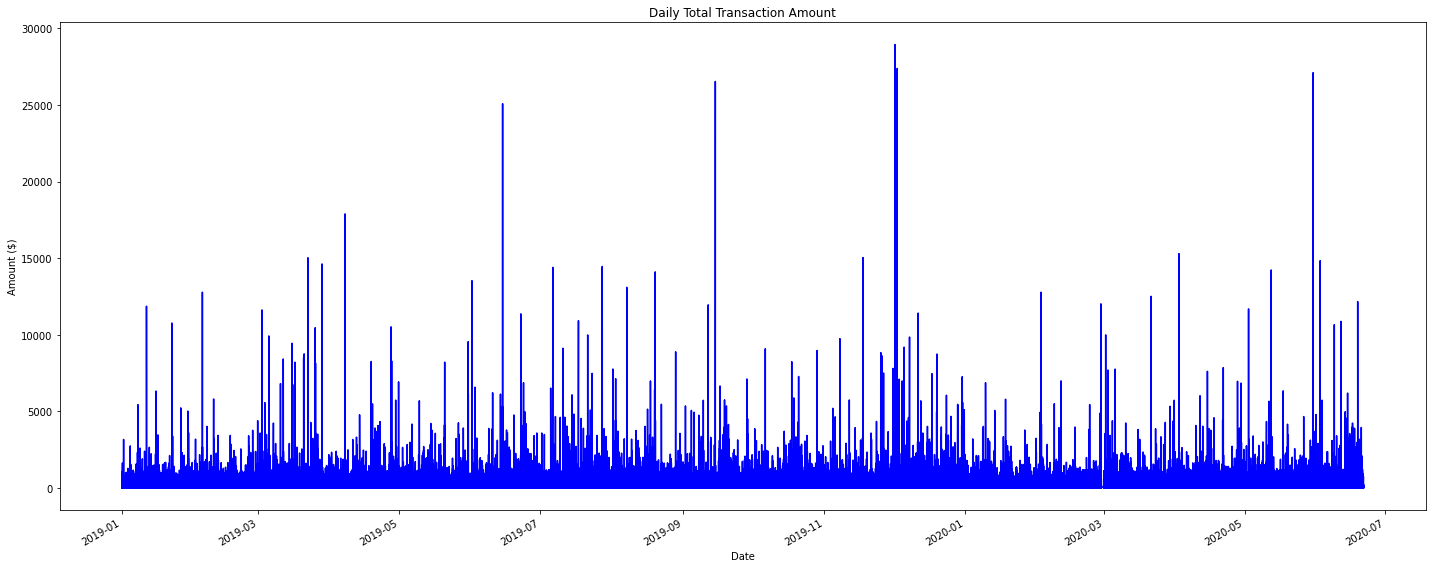

In [28]:
fig, ax = plt.subplots(figsize=(20, 8))
transaction_amt_sum = final_data.groupby('trans_date_trans_time')['amt'].sum()

transaction_amt_sum.plot(kind='line', color='blue')

plt.title('Daily Total Transaction Amount')
plt.ylabel('Amount ($)')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

Next, I would like to see how many category that contains the most fraud cases.

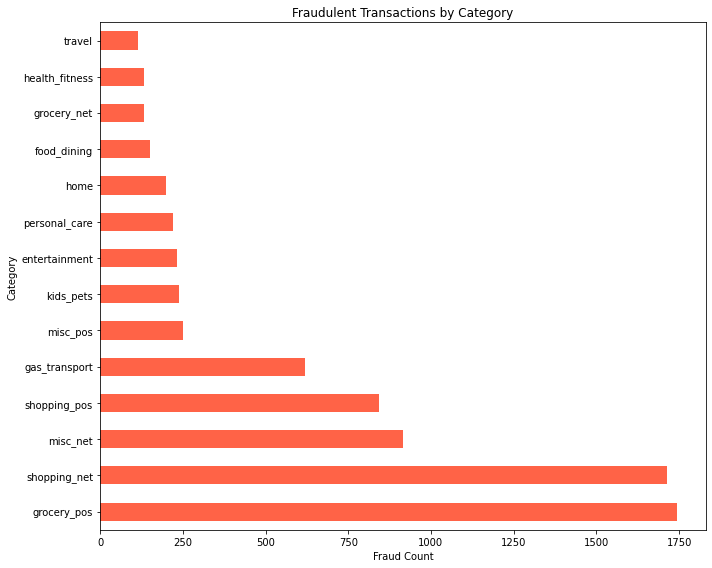

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))
fraud_category_count = final_data[final_data['is_fraud'] == 1]['category'].value_counts()

fraud_category_count.plot(kind='barh', color='tomato')
plt.title('Fraudulent Transactions by Category')
plt.xlabel('Fraud Count')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

Moving on, it is interesting to see how many cases happens in different states.

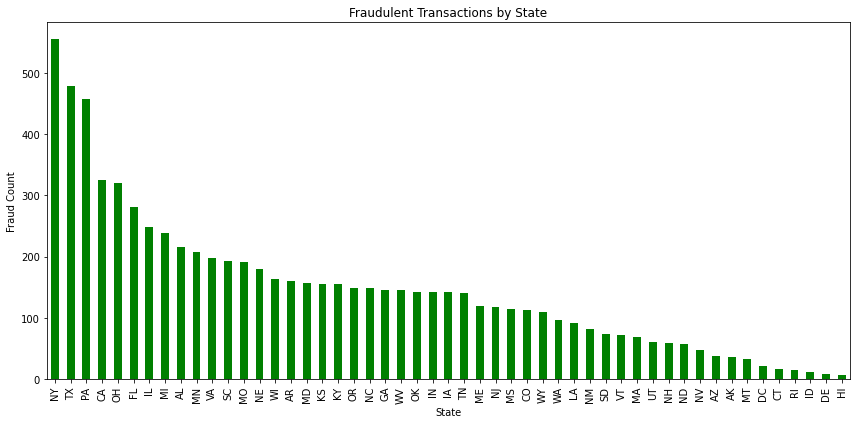

In [30]:
fig, ax = plt.subplots(figsize=(12, 6))
fraud_counts_by_state = final_data[final_data['is_fraud'] == 1]['state'].value_counts().sort_values(ascending=False)

fraud_counts_by_state.plot(kind='bar', color='green')
plt.title('Fraudulent Transactions by State')
plt.xlabel('State')
plt.ylabel('Fraud Count')
plt.tight_layout()
plt.show()

Next, we move into more details of the fraud cases. From the chart below, we are trying to see how high the rate of a certain category of being involved in fraud cases.

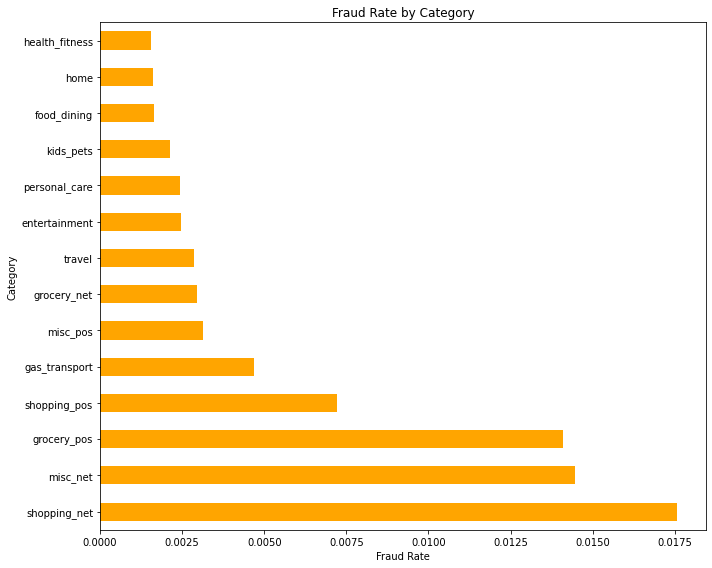

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
fraud_rate = final_data.groupby('category')['is_fraud'].mean().sort_values(ascending=False)

fraud_rate.plot(kind='barh', color='orange')
plt.title('Fraud Rate by Category')
plt.xlabel('Fraud Rate')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

Move on to more analysis based on transaction time, the charts below shows the following information:
1. The daily fraud rate. However, we can't really see a good trend from it. So, we will construct the next chart
2. The weekly fraud rate. From the week, we can see clearer trend from it.

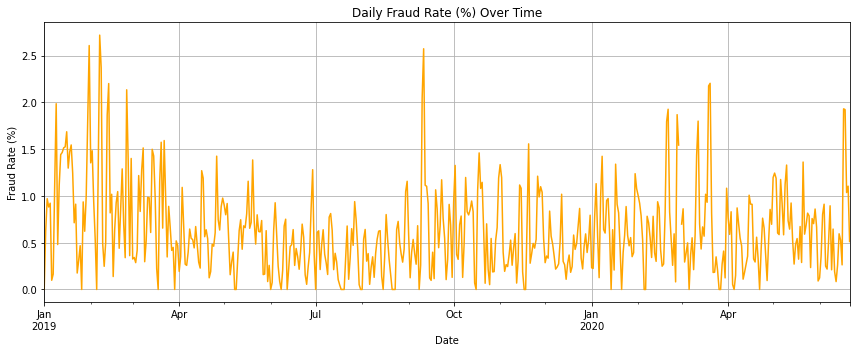

In [32]:
final_data_with_date_indexed = final_data.set_index('trans_date_trans_time')

fraud_rate = (final_data_with_date_indexed['is_fraud'].resample('D').sum() / final_data_with_date_indexed['is_fraud'].resample('D').count()) * 100  # in percentage

fraud_rate.plot(figsize=(12, 5), color='orange')
plt.title('Daily Fraud Rate (%) Over Time')
plt.xlabel('Date')
plt.ylabel('Fraud Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

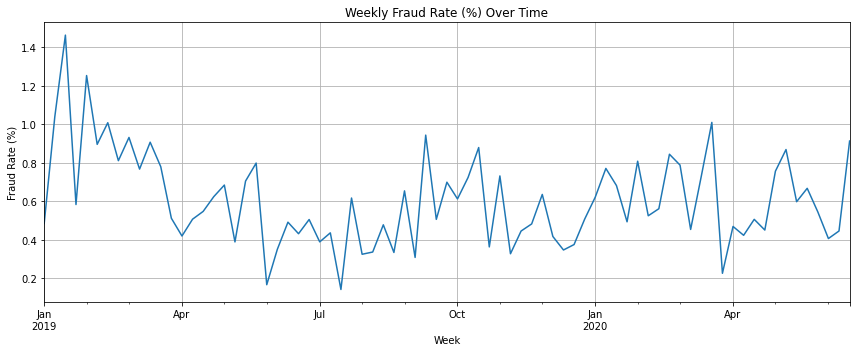

In [33]:
weekly_fraud_rate = (final_data_with_date_indexed['is_fraud'].resample('W').sum() / final_data_with_date_indexed['is_fraud'].resample('W').count()) * 100

weekly_fraud_rate.plot(figsize=(12, 5))
plt.title('Weekly Fraud Rate (%) Over Time')
plt.xlabel('Week')
plt.ylabel('Fraud Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()